# Query transformation

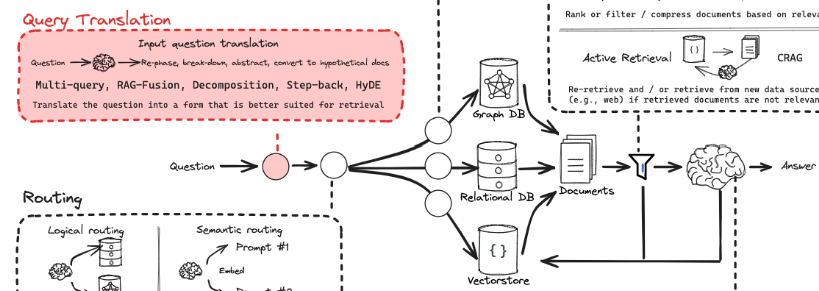

## Environment

In [1]:
from dotenv import load_dotenv
import os

In [2]:
load_dotenv()

LANGSMITH_API_KEY  = os.getenv("LANGSMITH_API_KEY")
GEMINI_API_KEY = os.getenv("GEMINI_API_KEY")

In [3]:
os.environ['LANGCHAIN_TRACING_V2'] = 'true'
os.environ['LANGCHAIN_ENDPOINT'] = 'https://api.smith.langchain.com'
os.environ['LANGCHAIN_API_KEY'] = LANGSMITH_API_KEY
os.environ['GOOGLE_API_KEY'] = GEMINI_API_KEY

## Part 5: Multi Query

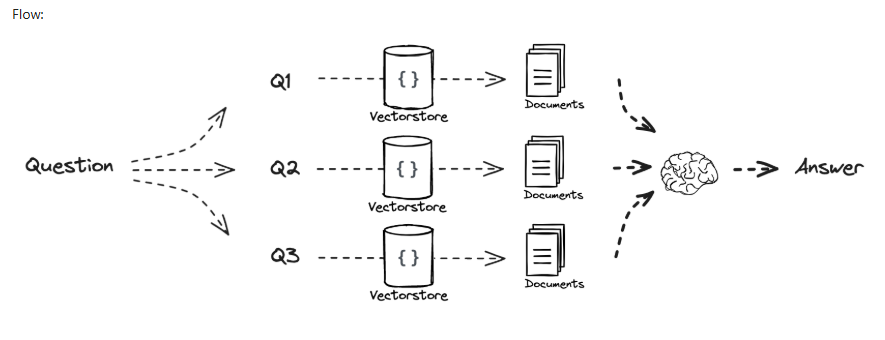

In [4]:
#Indexing

#loading
import bs4
from langchain_community.document_loaders import WebBaseLoader

loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
blog_docs = loader.load()

#splitting
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000, chunk_overlap=100
)
docs = text_splitter.split_documents(blog_docs)

#vectorizing
from langchain.vectorstores import Chroma
from langchain_google_genai import GoogleGenerativeAIEmbeddings

vectorstore = Chroma.from_documents(
    documents=docs,
    embedding=GoogleGenerativeAIEmbeddings(model="models/gemini-embedding-001")
)

#retriever
retriever = vectorstore.as_retriever(search_kwargs={"k":3})

USER_AGENT environment variable not set, consider setting it to identify your requests.


## prompt

In [5]:
from langchain.prompts import ChatPromptTemplate

template  = """You are an AI language model assistant. Your task is to generate five 
different versions of the given user question to retrieve relevant documents from a vector 
database. By generating multiple perspectives on the user question, your goal is to help
the user overcome some of the limitations of the distance-based similarity search. 
Provide these alternative questions separated by newlines. Original question: {question}"""

prompt_perspectives = ChatPromptTemplate.from_template(template)

from langchain_core.output_parsers import StrOutputParser
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(model="models/gemini-2.5-flash")

generate_queries = (
    prompt_perspectives | llm | StrOutputParser() | (lambda x: x.split("\n"))
)

In [6]:
from langchain.load import dumps, loads

def get_unique_union(documents: list[list]):
    """ Unique union of retrieved docs """
    # Flatten list of lists, and convert each Document to string
    flattened_docs = [dumps(doc) for sublist in documents for doc in sublist]
    # Get unique documents
    unique_docs = list(set(flattened_docs))
    # Return
    return [loads(doc) for doc in unique_docs]

In [7]:
# Retrieve
question = "What is task decomposition for LLM agents?"
retrieval_chain = generate_queries | retriever.map() | get_unique_union
docs = retrieval_chain.invoke({"question":question})
len(docs)

C:\Users\achin\AppData\Local\Temp\ipykernel_16936\170002541.py:10: LangChainBetaWarning: The function `loads` is in beta. It is actively being worked on, so the API may change.
  return [loads(doc) for doc in unique_docs]


5

In [8]:
from operator import itemgetter
from langchain_core.runnables import RunnablePassthrough

# RAG
template = """Answer the following question based on this context:

{context}

Question: {question}
"""

prompt = ChatPromptTemplate.from_template(template)

llm = ChatGoogleGenerativeAI(model="models/gemini-2.5-flash")

final_rag_chain = (
    {"context": retrieval_chain, 
     "question": itemgetter("question")} 
    | prompt
    | llm
    | StrOutputParser()
)

final_rag_chain.invoke({"question":question})

'Task decomposition for LLM agents is a crucial planning component where the agent breaks down large, complex tasks into smaller, more manageable subgoals or steps. This process enables efficient handling of complex tasks and improves the quality of final results.\n\nMethods for task decomposition include:\n*   **LLM with simple prompting:** Using prompts like "Steps for XYZ." or "What are the subgoals for achieving XYZ?".\n*   **Task-specific instructions:** Providing specific instructions, such as "Write a story outline." for writing a novel.\n*   **Human inputs:** Incorporating direct input from humans.\n*   **Chain of Thought (CoT):** A prompting technique where the model is instructed to "think step by step" to decompose hard tasks into simpler steps.\n*   **Tree of Thoughts (ToT):** An extension of CoT that explores multiple reasoning possibilities at each step, generating multiple thoughts per step in a tree structure.\n*   **LLM+P (external classical planner):** An approach tha

# Part 6: RAG-Fusion

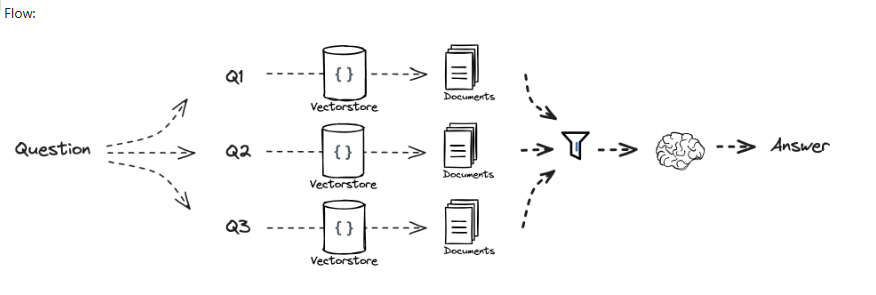

Langchain blog: 
https://towardsdatascience.com/forget-rag-the-future-is-rag-fusion-1147298d8ad1